### Check distribution of # of topics per document

In [15]:
TOPIC_BASE_DIR = "/home/guest/r12922050/GitHub/d2qplus/augmented-data/nfcorpus/topics/0606-biobert-mnli-reduce-outlier"

In [3]:
TOPIC_BASE_DIR = "/tmp"

Average number of topics per document: 3.0068813652628683
Max number of topics per document: 14
Min number of topics per document: 0


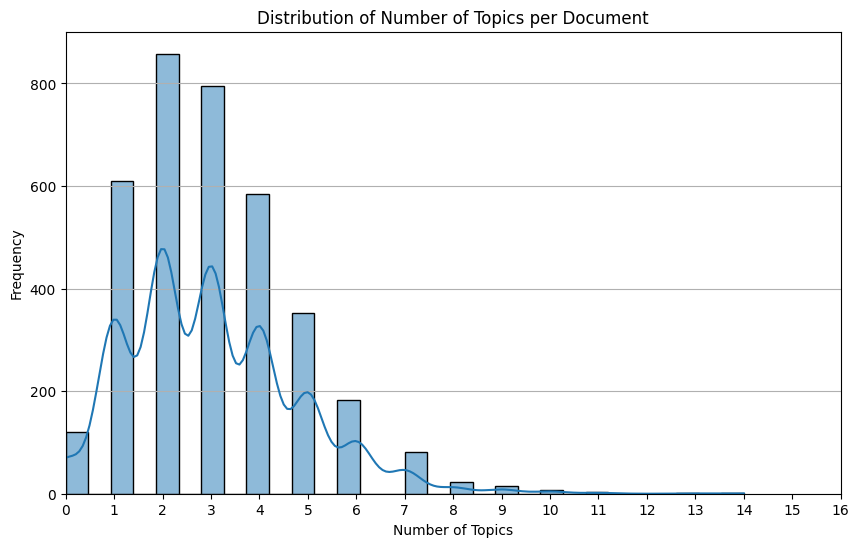

In [4]:
import json
with open(f"{TOPIC_BASE_DIR}/doc_topics.jsonl", "r") as f:
    corpus_topic = [json.loads(line) for line in f]
# average of topic num
topic_num = []
for doc in corpus_topic:
    topic_num.append(len(doc['topics']))

print(f"Average number of topics per document: {sum(topic_num) / len(topic_num)}")
print(f"Max number of topics per document: {max(topic_num)}")
print(f"Min number of topics per document: {min(topic_num)}")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(10, 6))
sns.histplot(topic_num, bins=30, kde=True)
plt.title('Distribution of Number of Topics per Document')
plt.xlabel('Number of Topics')
plt.ylabel('Frequency')
plt.xlim(0, 16)
plt.xticks(np.arange(0, 17, 1))
plt.grid(axis='y')
plt.show()

### check topic info dataframe

In [18]:
import pandas as pd

topic_info_df = pd.read_pickle(f"{TOPIC_BASE_DIR}/topic_info_dataframe.pkl")
display(topic_info_df)

,Topic,Count,Name,Representation,Representative_Docs
0,0,16928,0_and_of_in_the,"[and, of, in, the, to, for, with, was, were, d...",[RESULTS Mean BMI was lowest in vegans (23.6 k...
1,1,374,1_decreased_mmol_cholesterol_group,"[decreased, mmol, cholesterol, group, dl, mg d...",[Significant reductions were observed in LDL-C...
2,2,260,2_aged_years_health study_women,"[aged, years, health study, women, women aged,...",[Participants 66 105 women from the Nurses’ He...
3,3,241,3_no significant_no_significant differences_we...,"[no significant, no, significant differences, ...",[RESULTS: There were no significant difference...
4,4,234,4_curcumin_of curcumin_turmeric_curcuma,"[curcumin, of curcumin, turmeric, curcuma, tha...","[Curcumin (Cur), a component of turmeric (Curc..."
...,...,...,...,...,...
850,850,5,850_zinc_of zinc_rats fed_phytate,"[zinc, of zinc, rats fed, phytate, zinc metabo...",[Plasma zinc exchanged more rapidly with zinc ...
851,851,5,851_steps like_canning_drying_etc,"[steps like, canning, drying, etc, thermal, st...",[Various thermal processing treatments like pa...
852,852,5,852_their child_months postpartum_mothers_post...,"[their child, months postpartum, mothers, post...",[CONCLUSION: The vast majority of mothers over...
853,853,5,853_piperine_ahh_postmitochondrial supernatant...,"[piperine, ahh, postmitochondrial supernatant,...",[Piperine inhibition of these reactions in pos...


In [19]:
# write topic_info_df to a csv file
topic_info_df.to_csv(f"{TOPIC_BASE_DIR}/topic_info_dataframe.csv", index=False)

### Filter Representation using POS tagging

In [12]:
import pandas as pd
TOPIC_INFO_PICKLE = "/home/guest/r12922050/GitHub/d2qplus/augmented-data/nfcorpus/topics/0606-biobert-mnli/topic_info_dataframe.pkl"

topic_info_df = pd.read_pickle(TOPIC_INFO_PICKLE)
display(topic_info_df)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,16379,-1_and_of_the_in,"[and, of, the, in, to, for, were, with, was, i...",[RESULTS: In multivariate-logistic regression ...
1,0,508,0_vegetarians_vegetarian_vegan_omnivores,"[vegetarians, vegetarian, vegan, omnivores, ve...",[RESULTS Mean BMI was lowest in vegans (23.6 k...
2,1,432,1_decreased_cholesterol_ldl_mmol,"[decreased, cholesterol, ldl, mmol, 05, group,...",[Total and low-density lipoprotein (LDL) chole...
3,2,279,2_no significant_no_were no_significant differ...,"[no significant, no, were no, significant diff...",[RESULTS: There were no significant difference...
4,3,251,3_curcumin_of curcumin_turmeric_curcuma,"[curcumin, of curcumin, turmeric, curcuma, tha...",[Curcumin is the yellow pigment isolated from ...
...,...,...,...,...,...
839,838,5,838_immunostaining was_in any_immunostaining_n...,"[immunostaining was, in any, immunostaining, n...",[None of these products including the controls...
840,839,5,839_mtt_mtt assay_bromide mtt_by mtt,"[mtt, mtt assay, bromide mtt, by mtt, assay, v...",[Methods and results Cell proliferation and ce...
841,840,5,840_gases_charcoal containing_carbon fiber_odo...,"[gases, charcoal containing, carbon fiber, odo...",[The only product that adsorbed virtually all ...
842,841,5,841_industries_manufacturing_commodity industr...,"[industries, manufacturing, commodity industri...","[The strategy of ""manufacturing uncertainty"" h..."


In [2]:
from bertopic import BERTopic
topic_model = BERTopic.load("/home/guest/r12922050/GitHub/d2qplus/augmented-data/nfcorpus/topics/0605-biobert/bertopic_model")

In [5]:
all_topics = topic_model.get_topics()

In [6]:
for tid in all_topics.keys():
    if tid == -1:
        print(f"Topic {tid} is the outlier topic.")
        print(topic_model.get_topic(tid))
        break

Topic -1 is the outlier topic.
[('in', 0.0015526264042618988), ('the', 0.0015470998490340314), ('of', 0.0015406184756981594), ('and', 0.001498641020314179), ('to', 0.001459622480681719), ('that', 0.0014588326296348676), ('on', 0.0013597286226671877), ('as', 0.0013476458386830004), ('is', 0.0013392577686293097), ('this', 0.0013261930394164294), ('with', 0.001319766536553793), ('be', 0.0013069527396031757), ('are', 0.0012795711432484972), ('in the', 0.0012769387056145922), ('from', 0.001232174362927369), ('of the', 0.0012299046119901352), ('have', 0.0012254080433990767), ('for', 0.0012060990128021794), ('by', 0.0012010417256540786), ('was', 0.001174709124491037)]


In [ ]:
import argparse, json, collections, random, os, sys
import nltk; nltk.download("punkt", quiet=True)
from nltk import sent_tokenize
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, PartOfSpeech, MaximalMarginalRelevance
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

CORPUS_PATH = "/home/guest/r12922050/GitHub/d2qplus/data/nfcorpus/corpus.jsonl"
EMBED_MODEL = "pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb"

random.seed(42)

def sliding_windows(sentences, size=4, step=2):
    """Yield overlapping sentence windows."""
    i = 0
    while i < len(sentences):
        chunk = " ".join(sentences[i : i + size]).strip()
        if chunk:
            yield chunk
        i += step

def chunk_document(text, mode="sentence", win_size=4, win_step=2):
    """
    Break `text` into chunks according to `mode`.
    Returns a list of string chunks.
    """
    sents = sent_tokenize(text)
    if mode == "sentence":
        return [s.strip() for s in sents if s.strip()]
    elif mode == "window":
        return list(sliding_windows(sents, size=win_size, step=win_step))
    else:
        raise ValueError(f"Unknown chunk_mode: {mode}")


# Build chunks
chunks, chunk_owner = [], []
doc2chunk_idx = collections.defaultdict(list)

with open(CORPUS_PATH, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        doc_id, text = obj.get("_id"), obj.get("text", "")
        if doc_id is None or not isinstance(text, str):
            continue
        doc_chunks = chunk_document(text, mode="sentence")
        for ch in doc_chunks:
            idx = len(chunks)
            chunks.append(ch)
            chunk_owner.append(doc_id)
            doc2chunk_idx[doc_id].append(idx)

print(f"Built {len(chunks):,} chunks from {len(doc2chunk_idx):,} documents.")

# Initialize embedding model (ensure device is correct)
try:
    embedder = SentenceTransformer(EMBED_MODEL, device="cuda")
except Exception as e:
    print(f"Error loading embedder '{EMBED_MODEL}' on 'cuda': {e}", file=sys.stderr)
    sys.exit(1)


pos_patterns = [
    [{'POS': 'ADJ'},  {'POS': 'NOUN'}],   # adjective-noun, e.g. "gene expression"
    [{'POS': 'NOUN'}],                    # single noun,  e.g. "oncogene"
    [{'POS': 'PROPN'}]                    # proper noun  e.g. "CRISPR"
]

pos = PartOfSpeech("en_core_sci_sm", pos_patterns=pos_patterns, top_n_words=250)
keybert = KeyBERTInspired(nr_candidate_words=100, nr_repr_docs=5, top_n_words=25)
mmr = MaximalMarginalRelevance(diversity=0.6, top_n_words=10)

representation_chain = [pos, keybert, mmr]

vectorizer = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=5)

# Initialize BERTopic
topic_model = BERTopic(
    embedding_model=embedder,
    umap_model=UMAP(n_components=5, metric="cosine"),
    min_topic_size=5,
    vectorizer_model=vectorizer,
    representation_model=representation_chain,
    verbose=True
)

# Fit and transform
topics, probs = topic_model.fit_transform(chunks)

topic_model.get_topic_info()

Built 35,130 chunks from 3,633 documents.


2025-06-06 16:32:47,483 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1098/1098 [00:27<00:00, 39.28it/s]
2025-06-06 16:33:15,818 - BERTopic - Embedding - Completed ✓
2025-06-06 16:33:15,819 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-06 16:33:43,227 - BERTopic - Dimensionality - Completed ✓
2025-06-06 16:33:43,231 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-06 16:33:44,818 - BERTopic - Cluster - Completed ✓
2025-06-06 16:33:44,827 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-06 16:34:59,373 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,16375,-1_cholesterol_intakes_health_95 ci,"[cholesterol, intakes, health, 95 ci, cohort, ...",[The highest adherence to MD category resulted...
1,0,605,0_vegetarian diet_diet results_omnivores_fibre...,"[vegetarian diet, diet results, omnivores, fib...",[Cases of diabetes developed in 0.54% of vegan...
2,1,388,1_intake fish_methylmercury_health risks_polyu...,"[intake fish, methylmercury, health risks, pol...",[Discussion: There are many possible combinati...
3,2,277,2_groups results_remained unchanged_changes ob...,"[groups results, remained unchanged, changes o...","[In contrast, there were no statistically sign..."
4,3,237,3_curcumin_turmeric_chemopreventive_medicinal,"[curcumin, turmeric, chemopreventive, medicina...",[Although much has been published about curcum...
...,...,...,...,...,...
839,838,5,838_docosahexaenoic acid dha_fatty acid_omega_...,"[docosahexaenoic acid dha, fatty acid, omega, ...",[Docosahexaenoic acid (DHA) is an omega-3 fatt...
840,839,5,839_catechin_epicatechin_quercetin_genistein,"[catechin, epicatechin, quercetin, genistein, ...",[Autoradiography of cannabinoid receptors in b...
841,840,5,840_cancer risk_risk dietary_epidemiological s...,"[cancer risk, risk dietary, epidemiological st...","[Therefore, continued epidemiologic investigat..."
842,841,5,841_prevention dietary_supplements_antioxidant...,"[prevention dietary, supplements, antioxidant,...","[If these findings could be generalised, and i..."


In [22]:
TOPIC_BASE_DIR = "/home/guest/r12922050/GitHub/d2qplus/augmented-data/nfcorpus/topics/representations"
CORPUS_DOCS_OUTPUT_PATH = f"{TOPIC_BASE_DIR}/doc_topics.jsonl"
with open(CORPUS_DOCS_OUTPUT_PATH, "w", encoding="utf-8") as fout:
    for doc_id, idx_list in doc2chunk_idx.items():
        freq = collections.Counter(topics[i] for i in idx_list if topics[i] != -1)
        total = sum(freq.values())
        topic_entries = []
        for tid, cnt in freq.items():
            topic_entries.append({"topic_id": int(tid), "weight": round(cnt / total, 6)})
        fout.write(json.dumps({"doc_id": doc_id, "topics": topic_entries}, ensure_ascii=False) + "\n")

print(f"Wrote document-topic distributions to '{CORPUS_DOCS_OUTPUT_PATH}'")

Wrote document-topic distributions to '/home/guest/r12922050/GitHub/d2qplus/augmented-data/nfcorpus/topics/representations/doc_topics.jsonl'


In [1]:
topic_info_df = topic_model.get_topic_info()
topic_info_df.to_pickle(f"{TOPIC_BASE_DIR}/topic_info_dataframe.pkl")

NameError: name 'topic_model' is not defined

In [2]:
import pandas as pd
topic_info_df = pd.read_pickle("/home/guest/r12922050/GitHub/d2qplus/augmented-data/nfcorpus/topics/0606-pritamdeka-biobert-pos-keybert-mmr/topic_info_dataframe.pkl")
topic_info_df.to_csv(f"/home/guest/r12922050/GitHub/d2qplus/augmented-data/nfcorpus/topics/0606-pritamdeka-biobert-pos-keybert-mmr/topic_info_dataframe.csv", index=False)

### Enforce Minimum Topic for each document

In [ ]:
with open("/tmp/doc_topics.jsonl", "r") as f:
    corpus_topic = [json.loads(line) for line in f]
print("\n".join(f"{doc['doc_id']}: {doc['topics']}" for doc in corpus_topic[:5]))

CORPUS_PATH = "/home/guest/r12922050/GitHub/d2qplus/data/nfcorpus/corpus.jsonl"
corpus_text = {}
with open(CORPUS_PATH, "r", encoding="utf-8") as f:
    corpus_text = {json.loads(line).get("_id"): json.loads(line).get("text", "") for line in f}

print(f"Loaded {len(corpus_text):,} documents from '{CORPUS_PATH}'")

MED-10: [{'topic_id': 72, 'weight': 0.5}, {'topic_id': 59, 'weight': 0.25}, {'topic_id': 63, 'weight': 0.25}]
MED-14: [{'topic_id': 72, 'weight': 0.4}, {'topic_id': 813, 'weight': 0.2}, {'topic_id': 63, 'weight': 0.2}, {'topic_id': 12, 'weight': 0.2}]
MED-118: [{'topic_id': 569, 'weight': 0.8}, {'topic_id': 400, 'weight': 0.2}]
MED-301: [{'topic_id': 116, 'weight': 0.2}, {'topic_id': 785, 'weight': 0.2}, {'topic_id': 616, 'weight': 0.2}, {'topic_id': 483, 'weight': 0.4}]
MED-306: [{'topic_id': 280, 'weight': 0.222222}, {'topic_id': 78, 'weight': 0.444444}, {'topic_id': 2, 'weight': 0.111111}, {'topic_id': 83, 'weight': 0.111111}, {'topic_id': 695, 'weight': 0.111111}]
Loaded 3,633 documents from '/home/guest/r12922050/GitHub/d2qplus/data/nfcorpus/corpus.jsonl'


In [ ]:
for doc in corpus_topic:
    if len(doc['topics']) < 2:
        print(f"Document {doc['doc_id']} has less than 2 topics: {doc['topics']}")
        
        sents = chunk_document(corpus_text[doc['doc_id']])
        print(f"Document {doc['doc_id']} has only {len(doc['topics'])} topic(s), but {len(sents)} sentences.")
        print(f"Text: {corpus_text[doc['doc_id']]}")
        
        # use soft distribution over all topics
        sent_dists = topic_model.approximate_distribution(sents)[0]
        top1_per_sent = np.argmax(sent_dists, axis=1)
        for topic in set(top1_per_sent):
            print(f"Topic {topic}: {topic_model.get_topic(topic)}")
        break


Document MED-332 has less than 2 topics: [{'topic_id': 18, 'weight': 1.0}]
Document MED-332 has only 1 topic(s), but 8 sentences.
Text: This review explores the potential adverse impact of the increasing phosphorus content in the American diet on renal, cardiovascular, and bone health of the general population. Increasingly, studies show that phosphorus intakes in excess of the nutrient needs of a healthy population may significantly disrupt the hormonal regulation of phosphate, calcium, and vitamin D, which contributes to disordered mineral metabolism, vascular calcification, impaired kidney function, and bone loss. Moreover, large epidemiologic studies suggest that mild elevations of serum phosphate within the normal range are associated with cardiovascular disease (CVD) risk in healthy populations without evidence of kidney disease. However, few studies linked high dietary phosphorus intake to mild changes in serum phosphate because of the nature of the study design and inaccuracies

100%|██████████| 1/1 [00:00<00:00, 27.98it/s]

Topic 64: [('endocrine', 0.03452835714743812), ('disrupting', 0.012987390975246404), ('chemicals', 0.012197652256695732), ('endocrine disruption', 0.011436961461891671), ('endocrine disrupting', 0.011211927121364866), ('endocrine disruptors', 0.008969541697091894), ('disruptors', 0.008969541697091894), ('disruption', 0.008612284532314399), ('exposure to', 0.007912359637821414), ('chemicals with', 0.007903260915948998), ('disrupting chemicals', 0.007903260915948998), ('disrupters', 0.007903260915948998), ('endocrine disrupters', 0.007903260915948998), ('an endocrine', 0.007616525099553058), ('endocrine disruptor', 0.007616525099553058), ('between exposure', 0.007616525099553058), ('environment', 0.007390163858584282), ('disruptor', 0.00738237198219534), ('estrogens', 0.007102737934657665), ('with hormone', 0.006862176877135003)]
Topic 18: [('phosphorus', 0.04900100163472211), ('phosphate', 0.025000051650600184), ('additives', 0.01944853804788), ('phosphorus content', 0.01692979412943063

In [34]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,13699,-1_the_of_in_and,"[the, of, in, and, to, for, were, on, with, that]","[Among premenopausal women only, there was a r..."
1,0,522,0_vegetarians_vegetarian_vegan_omnivores,"[vegetarians, vegetarian, vegan, omnivores, ve...",[Cases of diabetes developed in 0.54% of vegan...
2,1,348,1_decreased_mg dl_dl_cholesterol,"[decreased, mg dl, dl, cholesterol, mmol, 05, ...",[Total cholesterol/high-density lipoprotein an...
3,2,249,2_no significant_were no_significant differenc...,"[no significant, were no, significant differen...",[There were no statistically significant diffe...
4,3,253,3_food frequency_questionnaire_frequency quest...,"[food frequency, questionnaire, frequency ques...",[Diet was assessed by using food-frequency que...
...,...,...,...,...,...
847,846,6,846_injection q3dx5_q3dx5_injection_mouse inje...,"[injection q3dx5, q3dx5, injection, mouse inje...",[Cetuximab treatment alone (0.25-1 mg/mouse/in...
848,847,5,847_green tea_tea_green_gallate,"[green tea, tea, green, gallate, scavenging, e...",[Therefore the cytoprotective effects of green...
849,848,9,848_occupational_non occupational_asbestos_occ...,"[occupational, non occupational, asbestos, occ...",[This paper reviews existing data related to n...
850,849,10,849_like growth_insulin like_igf_growth factor,"[like growth, insulin like, igf, growth factor...",[BACKGROUND: Insulin-like growth factor (IGF)-...
